### Course Popularity - Final Project for CSC440: Data Mining


In [43]:
from pathlib import Path
import pandas as pd
import numpy as np
import gc
import sys
import io

from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit
from xgboost import XGBRegressor

# Visualization imports
import matplotlib.pyplot as plt
import seaborn as sns

# Set style for all plots
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12

# ============================================================
# 0. Load CSVs
# ============================================================
sections_file_path = Path("Data") / "Course_data" / "courses.sections.csv"
sectionsTS_file_path = Path("Data") / "Course_data" / "courses.sectionsTS.csv"

sections_df = pd.read_csv(sections_file_path, low_memory=False)
sections_ts_df = pd.read_csv(sectionsTS_file_path)

print("\n========== Loaded Datasets ==========")
print("courses.sections.csv info:")
print(sections_df.info(), "\n")

print("courses.sectionsTS.csv info:")
print(sections_ts_df.info(), "\n")

print("Static sections columns:", sections_df.columns)
print("Time-series columns:", sections_ts_df.columns)


========== Loaded Datasets ==========
courses.sections.csv info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29441 entries, 0 to 29440
Columns: 162 entries, _id to topic[4]
dtypes: bool(1), float64(2), int64(4), object(155)
memory usage: 36.2+ MB
None 

courses.sectionsTS.csv info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1085294 entries, 0 to 1085293
Data columns (total 10 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   dateTimeRetrieved       1085294 non-null  object 
 1   courseInfo.classNumber  1085294 non-null  int64  
 2   courseInfo.semester     1085294 non-null  object 
 3   courseInfo.year         1085294 non-null  int64  
 4   _id                     1085294 non-null  object 
 5   seatsAvailable          1085294 non-null  int64  
 6   status                  1085294 non-null  object 
 7   waitlistAvailable       773996 non-null   float64
 8   reservedSeatsAvailable  12257 non-null    

In [44]:
# ============================================================
# 1. Helper: Build Data Quality Report for a DataFrame
# ============================================================

def build_dq_report(df: pd.DataFrame, df_name: str):
    """
    Perform data quality checks, print all results, and return BOTH:
    - cleaned DataFrame
    - string report suitable for writing to a .txt file

    Special handling:
    - Treat 'courseInfo.classNumber' and 'courseInfo.year' as categorical,
      even if they are stored as numbers.
    """
    output = []  # collect all console lines into a list

    def log(msg=""):
        print(msg)
        output.append(str(msg))

    # ---------- Force certain numeric-looking columns to categorical ----------
    forced_categorical_cols = ["courseInfo.classNumber", "courseInfo.year"]
    for col in forced_categorical_cols:
        if col in df.columns:
            # Cast to string dtype so they behave like categorical/text
            df[col] = df[col].astype("string")

    log("\n\n============================================================")
    log(f"############  DATA QUALITY REPORT: {df_name}  ############")
    log("============================================================\n")

    # ---------- Overview ----------
    log("---- Overview ----")
    overview = pd.DataFrame({
        "n_rows": [df.shape[0]],
        "n_columns": [df.shape[1]],
        "n_duplicates": [df.duplicated().sum()]
    })
    log(overview.to_string())
    log("")

    # ---------- Null Summary ----------
    log("---- Null Summary (All Columns) ----")
    null_summary = pd.DataFrame({
        "column": df.columns,
        "dtype": df.dtypes.values.astype(str),
        "null_count": df.isna().sum().values,
        "null_pct": (df.isna().mean() * 100).values
    }).sort_values("null_pct", ascending=False)
    log(null_summary.to_string(index=False))
    log("")

    # ---------- Dtype Summary ----------
    log("---- Dtype Summary ----")
    dtype_summary = (
        null_summary[["column", "dtype"]]
        .groupby("dtype")
        .agg(n_columns=("column", "count"),
             columns=("column", lambda x: ", ".join(x)))
        .reset_index()
    )
    log(dtype_summary.to_string(index=False))
    log("")

    # ---------- Numeric Summary ----------
    log("---- Numeric Summary ----")

    numeric_cols = df.select_dtypes(include=[np.number]).columns  # numeric columns
    ignore_cols = {"courseInfo.classNumber", "courseInfo.year"}   # columns to treat as categorical
    numeric_cols = [c for c in numeric_cols if c not in ignore_cols]  # filter them out

    if len(numeric_cols) > 0:
        numeric_summary = df[numeric_cols].describe().T
        numeric_summary["missing_count"] = df[numeric_cols].isna().sum()
        numeric_summary["missing_pct"] = df[numeric_cols].isna().mean() * 100
        log(numeric_summary.to_string())
    else:
        log("No numeric columns.")
    log("")

    # ---------- Categorical Summary ----------
    log("---- Categorical Summary ----")
    cat_cols = df.select_dtypes(include=["object", "category", "string"]).columns
    cat_summary_rows = []

    for col in cat_cols:
        series = df[col]

        # SPECIAL CASE: Avoid lists of large uniques value-counts in columns
        if (col in ["_id", "name", "dateTimeRetrieved", "sectionCode"] or 
            col.startswith("instructor") or col.startswith("classroom") or 
            col.startswith("timeStart") or col.startswith("timeEnd") or
            col.startswith("startDate") or col.startswith("endDate")):

            value_counts_str = "[SKIPPED - too many unique values]"
        else:
            # full list of value counts
            value_counts_str = ", ".join(
                [f"{idx}({val})" for idx, val in series.value_counts(dropna=True).items()]
            )

        cat_summary_rows.append({
            "column": col,
            "dtype": str(series.dtype),
            "n_unique": series.nunique(dropna=True),
            "missing_pct": series.isna().mean() * 100,
            "value_counts": value_counts_str
        })

    if cat_summary_rows:
        cat_summary = pd.DataFrame(cat_summary_rows)
        log(cat_summary.to_string(index=False))
    else:
        log("No categorical columns.")
    log("")

    # ---------- Type Coercion Checks ----------
    log("---- Type Coercion Checks ----")

    expected_numeric_cols = [
        "capacity", "waitlistCapacity", "reservedSeatsAvailable",
        "reservedSeatsCapacity", "year", "catalogNumber", "classNumber"
        # NOTE: we do NOT include 'courseInfo.classNumber' or 'courseInfo.year' here
    ]
    expected_datetime_cols = [
        "dateTimeRetrieved", "timeStart", "timeEnd",
        "startDate", "endDate"
    ]

    log("\nNumeric Columns Coercion Results:")
    for col in expected_numeric_cols:
        if col in df.columns:
            before = df[col].notna().sum()
            coerced = pd.to_numeric(df[col], errors="coerce")
            after = coerced.notna().sum()
            log(f"{col}: non-null before={before}, after={after}, invalid={before - after}")
            df[col] = coerced

    log("\nDatetime Columns Coercion Results:")
    for col in expected_datetime_cols:
        if col in df.columns:
            before = df[col].notna().sum()
            coerced = pd.to_datetime(df[col], errors="coerce")
            after = coerced.notna().sum()
            log(f"{col}: non-null before={before}, after={after}, invalid={before - after}")
            df[col] = coerced

    log(f"\n========== END OF REPORT FOR: {df_name} ==========\n")

    # Return cleaned df + FULL text output
    return df, "\n".join(output)

# ============================================================
# 2. Run Reports for Each Dataset
# ============================================================

sections_df, sections_report_txt = build_dq_report(sections_df.copy(), "courses.sections")
sections_ts_df, sectionsTS_report_txt = build_dq_report(sections_ts_df.copy(), "courses.sectionsTS")

gc.collect()

print("\n ########## Data quality analysis completed. ##########\n")

# ============================================================
# 3. SAVE REPORT TO TEXT FILE
# ============================================================

output_path = Path("Dataset-Report.txt")
with open(output_path, "w", encoding="utf-8") as f:
    f.write(sections_report_txt)
    f.write("\n\n")
    f.write(sectionsTS_report_txt)

print(f"Dataset report written to: {output_path.resolve()}")




############  DATA QUALITY REPORT: courses.sections  ############

---- Overview ----
   n_rows  n_columns  n_duplicates
0   29441        162             0

---- Null Summary (All Columns) ----
                column   dtype  null_count  null_pct
          startDate[8]  object       29440 99.996603
            days[3][3]  object       29440 99.996603
        instructor[13]  object       29440 99.996603
        instructor[12]  object       29440 99.996603
      instructor[8][0]  object       29440 99.996603
        instructor[11]  object       29440 99.996603
            days[8][0]  object       29440 99.996603
            days[2][3]  object       29440 99.996603
            days[3][2]  object       29440 99.996603
            days[4][2]  object       29440 99.996603
            endDate[8]  object       29440 99.996603
            days[4][3]  object       29440 99.996603
          timeStart[8]  object       29440 99.996603
            timeEnd[8]  object       29440 99.996603
         

In [45]:
# ============================================================
# Fix duplicate / typo columns: waitlistAvailable vs wailistAvailable
# ============================================================
if "waitlistAvailable" in sections_ts_df.columns and "wailistAvailable" in sections_ts_df.columns:
    col_good = sections_ts_df["waitlistAvailable"]
    col_typo = sections_ts_df["wailistAvailable"]

    # Where both have values and differ, count mismatches
    both_non_null = col_good.notna() & col_typo.notna()
    mismatches = (both_non_null & (col_good != col_typo)).sum()

    print(f"\n[Data Fix] waitlistAvailable vs wailistAvailable:")
    print(f"  Rows where BOTH are non-null: {both_non_null.sum()}")
    print(f"  Rows where values MISMATCH:  {mismatches}")

    # Merge logic (intersection-style):
    # - If both non-null and equal → keep that value
    # - If only one is non-null       → use the non-null value
    # - If both non-null and different → set NaN (and rely on later checks)
    merged = np.where(
        both_non_null & (col_good == col_typo),
        col_good,                     # agree → keep
        np.where(
            col_good.notna() & ~col_typo.notna(),
            col_good,                 # only good has value
            np.where(
                col_typo.notna() & ~col_good.notna(),
                col_typo,             # only typo has value
                np.nan                # mismatch or both null
            )
        )
    )

    sections_ts_df["waitlistAvailable"] = merged

    # Drop the bad column
    sections_ts_df = sections_ts_df.drop(columns=["wailistAvailable"])

    print("  -> Merged into 'waitlistAvailable' and dropped 'wailistAvailable'.\n")

else:
    print("\n[Data Fix] One or both columns 'waitlistAvailable' / 'wailistAvailable' not found; no merge performed.\n")


[Data Fix] waitlistAvailable vs wailistAvailable:
  Rows where BOTH are non-null: 0
  Rows where values MISMATCH:  0
  -> Merged into 'waitlistAvailable' and dropped 'wailistAvailable'.



In [46]:
# ===============================================================
# 2. Merge Static Course Metadata with Time-Series Observations
#    (Intersection merge on classNumber + semester)
# ===============================================================

# Reload fresh data to ensure subjectCode is preserved correctly
sections_df_fresh = pd.read_csv(sections_file_path, low_memory=False)

# Columns we want to bring in from the time-series file
ts_cols_to_keep = [
    "courseInfo.classNumber",
    "courseInfo.semester",
    "dateTimeRetrieved",
    "seatsAvailable",
    "status",
    "waitlistAvailable",
]

# Rename to avoid conflicts with static df columns
sections_ts_subset = sections_ts_df[ts_cols_to_keep].copy()
sections_ts_subset = sections_ts_subset.rename(columns={
    "dateTimeRetrieved": "ts_dateTimeRetrieved"
})

# Ensure merge keys have compatible types (both as int64)
sections_df_fresh["classNumber"] = pd.to_numeric(sections_df_fresh["classNumber"], errors="coerce").astype("Int64")
sections_ts_subset["courseInfo.classNumber"] = pd.to_numeric(sections_ts_subset["courseInfo.classNumber"], errors="coerce").astype("Int64")

# Ensure semester columns are both strings
sections_df_fresh["semester"] = sections_df_fresh["semester"].astype(str)
sections_ts_subset["courseInfo.semester"] = sections_ts_subset["courseInfo.semester"].astype(str)

print(f"sections_df_fresh classNumber dtype: {sections_df_fresh['classNumber'].dtype}")
print(f"sections_ts_subset courseInfo.classNumber dtype: {sections_ts_subset['courseInfo.classNumber'].dtype}")
print(f"Unique subjectCodes in fresh data: {sections_df_fresh['subjectCode'].nunique()}")

# Perform an "intersection" merge (inner join) on classNumber + semester
df = sections_df_fresh.merge(
    sections_ts_subset,
    left_on=["classNumber", "semester"],
    right_on=["courseInfo.classNumber", "courseInfo.semester"],
    how="inner"  # <- intersection merge
)

# Drop duplicate key columns from the TS side
df = df.drop(columns=["courseInfo.classNumber", "courseInfo.semester"])

# Convert timestamps (use the renamed column)
df["dateTimeRetrieved"] = pd.to_datetime(df["ts_dateTimeRetrieved"], errors="coerce")
df = df.drop(columns=["ts_dateTimeRetrieved"])

# Sort by classNumber and timestamp
df = df.sort_values(["classNumber", "dateTimeRetrieved"])

print(f"Merged dataframe shape: {df.shape}")
print(f"Merged dataframe columns: {len(df.columns)}")


sections_df_fresh classNumber dtype: Int64
sections_ts_subset courseInfo.classNumber dtype: Int64
Unique subjectCodes in fresh data: 135
Merged dataframe shape: (1742552, 165)
Merged dataframe columns: 165


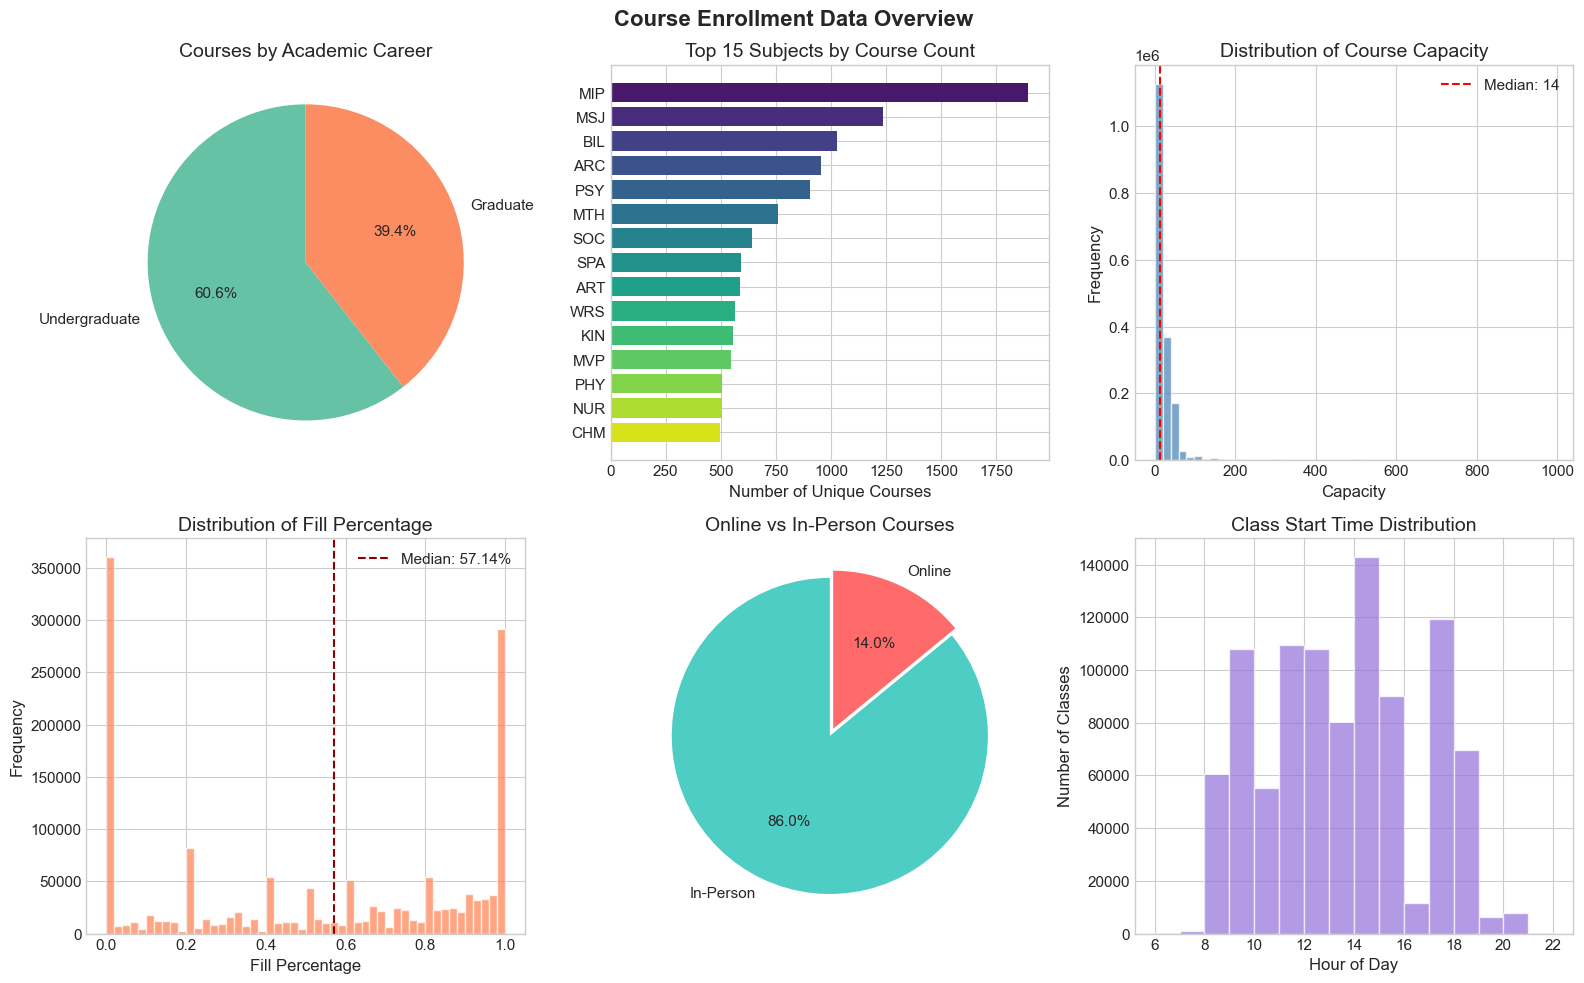


📊 Data Summary:
   Total observations: 1,742,552
   Unique courses: 10,672
   Subject areas: 135
   Date range: 2024-11-04 to 2025-04-11


In [47]:
# ===============================================================
# VISUALIZATION 1: Data Overview & Distribution
# ===============================================================

fig, axes = plt.subplots(2, 3, figsize=(16, 10))
fig.suptitle('Course Enrollment Data Overview', fontsize=16, fontweight='bold')

# 1. Distribution of courses by academic career
ax1 = axes[0, 0]
career_counts = df['academicCareer'].value_counts()
colors = sns.color_palette("Set2", len(career_counts))
ax1.pie(career_counts.values, labels=career_counts.index, autopct='%1.1f%%', colors=colors, startangle=90)
ax1.set_title('Courses by Academic Career')

# 2. Top 15 subjects by number of courses
ax2 = axes[0, 1]
subject_counts = df.groupby('subjectCode')['classNumber'].nunique().sort_values(ascending=False).head(15)
bars = ax2.barh(subject_counts.index, subject_counts.values, color=sns.color_palette("viridis", 15))
ax2.set_xlabel('Number of Unique Courses')
ax2.set_title('Top 15 Subjects by Course Count')
ax2.invert_yaxis()

# 3. Capacity distribution
ax3 = axes[0, 2]
ax3.hist(df['capacity'].dropna(), bins=50, color='steelblue', edgecolor='white', alpha=0.7)
ax3.axvline(df['capacity'].median(), color='red', linestyle='--', label=f'Median: {df["capacity"].median():.0f}')
ax3.set_xlabel('Capacity')
ax3.set_ylabel('Frequency')
ax3.set_title('Distribution of Course Capacity')
ax3.legend()

# 4. Seats Available distribution (computed inline)
ax4 = axes[1, 0]
# Compute fill percentage inline (seats_taken / capacity)
temp_fill_pct = (df['capacity'] - df['seatsAvailable']) / df['capacity'].replace(0, np.nan)
fill_pct_clean = temp_fill_pct.dropna()
fill_pct_clean = fill_pct_clean[(fill_pct_clean >= 0) & (fill_pct_clean <= 1.5)]
ax4.hist(fill_pct_clean, bins=50, color='coral', edgecolor='white', alpha=0.7)
ax4.axvline(fill_pct_clean.median(), color='darkred', linestyle='--', label=f'Median: {fill_pct_clean.median():.2%}')
ax4.set_xlabel('Fill Percentage')
ax4.set_ylabel('Frequency')
ax4.set_title('Distribution of Fill Percentage')
ax4.legend()

# 5. Online vs In-Person (computed inline)
ax5 = axes[1, 1]
# Check if classroom contains "Online"
temp_is_online = df['classroom'].fillna("").str.contains("Online", case=False)
online_counts = df.groupby('classNumber').apply(lambda x: x['classroom'].fillna("").str.contains("Online", case=False).any()).value_counts()
labels = ['In-Person', 'Online'] if False in online_counts.index else ['Online', 'In-Person']
ax5.pie(online_counts.values, labels=labels, autopct='%1.1f%%', colors=['#4ECDC4', '#FF6B6B'], startangle=90, explode=[0, 0.05])
ax5.set_title('Online vs In-Person Courses')

# 6. Time of day distribution (class start times)
ax6 = axes[1, 2]
# Convert timeStart to datetime if needed
temp_timestart = pd.to_datetime(df['timeStart'], errors='coerce')
start_hours = temp_timestart.dt.hour.dropna()
ax6.hist(start_hours, bins=range(6, 23), color='mediumpurple', edgecolor='white', alpha=0.7)
ax6.set_xlabel('Hour of Day')
ax6.set_ylabel('Number of Classes')
ax6.set_title('Class Start Time Distribution')
ax6.set_xticks(range(6, 23, 2))

plt.tight_layout()
plt.show()

print(f"\n📊 Data Summary:")
print(f"   Total observations: {len(df):,}")
print(f"   Unique courses: {df['classNumber'].nunique():,}")
print(f"   Subject areas: {df['subjectCode'].nunique()}")
print(f"   Date range: {df['dateTimeRetrieved'].min().date()} to {df['dateTimeRetrieved'].max().date()}")


In [48]:
# ===============================================================
# 3. Feature Engineering
# ===============================================================

# ---- Temporal Features ----
df["days_since_start"] = df.groupby("classNumber")["dateTimeRetrieved"] \
                           .transform(lambda x: (x - x.min()).dt.total_seconds() / 86400)

df["hour"] = df["dateTimeRetrieved"].dt.hour
df["day_of_week"] = df["dateTimeRetrieved"].dt.dayofweek # 0=Monday, ..., 6=Sunday
df["is_weekend"] = df["day_of_week"].isin([5,6]).astype(int) # 5=Saturday, 6=Sunday

# Cyclical time encoding
df["hour_sin"] = np.sin(2 * np.pi * df["hour"] / 24)
df["hour_cos"] = np.cos(2 * np.pi * df["hour"] / 24)
df["dow_sin"] = np.sin(2 * np.pi * df["day_of_week"] / 7)
df["dow_cos"] = np.cos(2 * np.pi * df["day_of_week"] / 7)

# ---- Enrollment Features ----
df["seats_taken"] = df["capacity"] - df["seatsAvailable"]
df["fill_pct"] = df["seats_taken"] / df["capacity"].replace(0, np.nan)

df["waitlist_ratio"] = df["waitlistAvailable"] / df["waitlistCapacity"].replace(0, np.nan)

# ---- Velocity Metrics ----
df["fill_velocity_per_day"] = df.groupby("classNumber")["fill_pct"].diff() / \
                              df.groupby("classNumber")["days_since_start"].diff()

df["rolling_velocity_6h"] = df.groupby("classNumber")["fill_pct"].transform(
    lambda x: x.diff().rolling(6).mean()
)

# Fill acceleration (rate of change of velocity) - REQUIRED per proposal
df["fill_acceleration"] = df.groupby("classNumber")["fill_velocity_per_day"].diff()

# Observation sequence number per course - REQUIRED per proposal
df["observation_sequence"] = df.groupby("classNumber").cumcount() + 1

# Seats remaining percentage - REQUIRED per proposal
df["seats_remaining_pct"] = df["seatsAvailable"] / df["capacity"].replace(0, np.nan)

# ---- Course-Level Features ----
# Convert catalogNumber to numeric (some may be strings like "220" or alphanumeric)
df["catalogNumber"] = pd.to_numeric(df["catalogNumber"], errors="coerce")
df["course_level"] = df["catalogNumber"] // 100
# Check if classroom contains "Online" (handles "Online Instruction ONL" etc.)
df["is_online"] = df["classroom"].fillna("").str.contains("Online", case=False).astype(int)

df["timeStart"] = pd.to_datetime(df["timeStart"], errors="coerce")
df["early_morning"] = (df["timeStart"].dt.hour < 10).astype(int)
df["evening"] = (df["timeStart"].dt.hour >= 17).astype(int)

print(f"Feature engineering complete. DataFrame shape: {df.shape}")
gc.collect()

Feature engineering complete. DataFrame shape: (1742552, 185)


32

In [49]:
# ===============================================================
# 4. Modeling Dataset Construction
# ===============================================================
target = "fill_pct"

feature_cols = [
    "days_since_start", "hour_sin", "hour_cos", "dow_sin", "dow_cos",
    "is_weekend", "seats_taken", "capacity", "waitlist_ratio",
    "fill_velocity_per_day", "rolling_velocity_6h",
    "fill_acceleration", "observation_sequence", "seats_remaining_pct",  # Added per proposal
    "course_level", "is_online", "early_morning", "evening"
]

# Preserve subjectCode before one-hot encoding (needed for popularity metrics later)
# Use a name that won't be picked up by the feature_cols filter
df["original_subjectCode"] = df["subjectCode"].copy()

# One-hot encode subjectCode & academicCareer
df = pd.get_dummies(df, columns=["subjectCode", "academicCareer"], drop_first=True)

feature_cols.extend([col for col in df.columns if col.startswith("subjectCode_")])
feature_cols.extend([col for col in df.columns if col.startswith("academicCareer_")])

df = df.dropna(subset=[target])

X = df[feature_cols].copy()
y = df[target].copy()

# Replace infinite values with NaN, then fill with 0
X = X.replace([np.inf, -np.inf], np.nan)
X = X.fillna(0)

print(f"Features: {len(feature_cols)} columns")
print(f"Training samples: {len(X)}")

Features: 153 columns
Training samples: 1742551


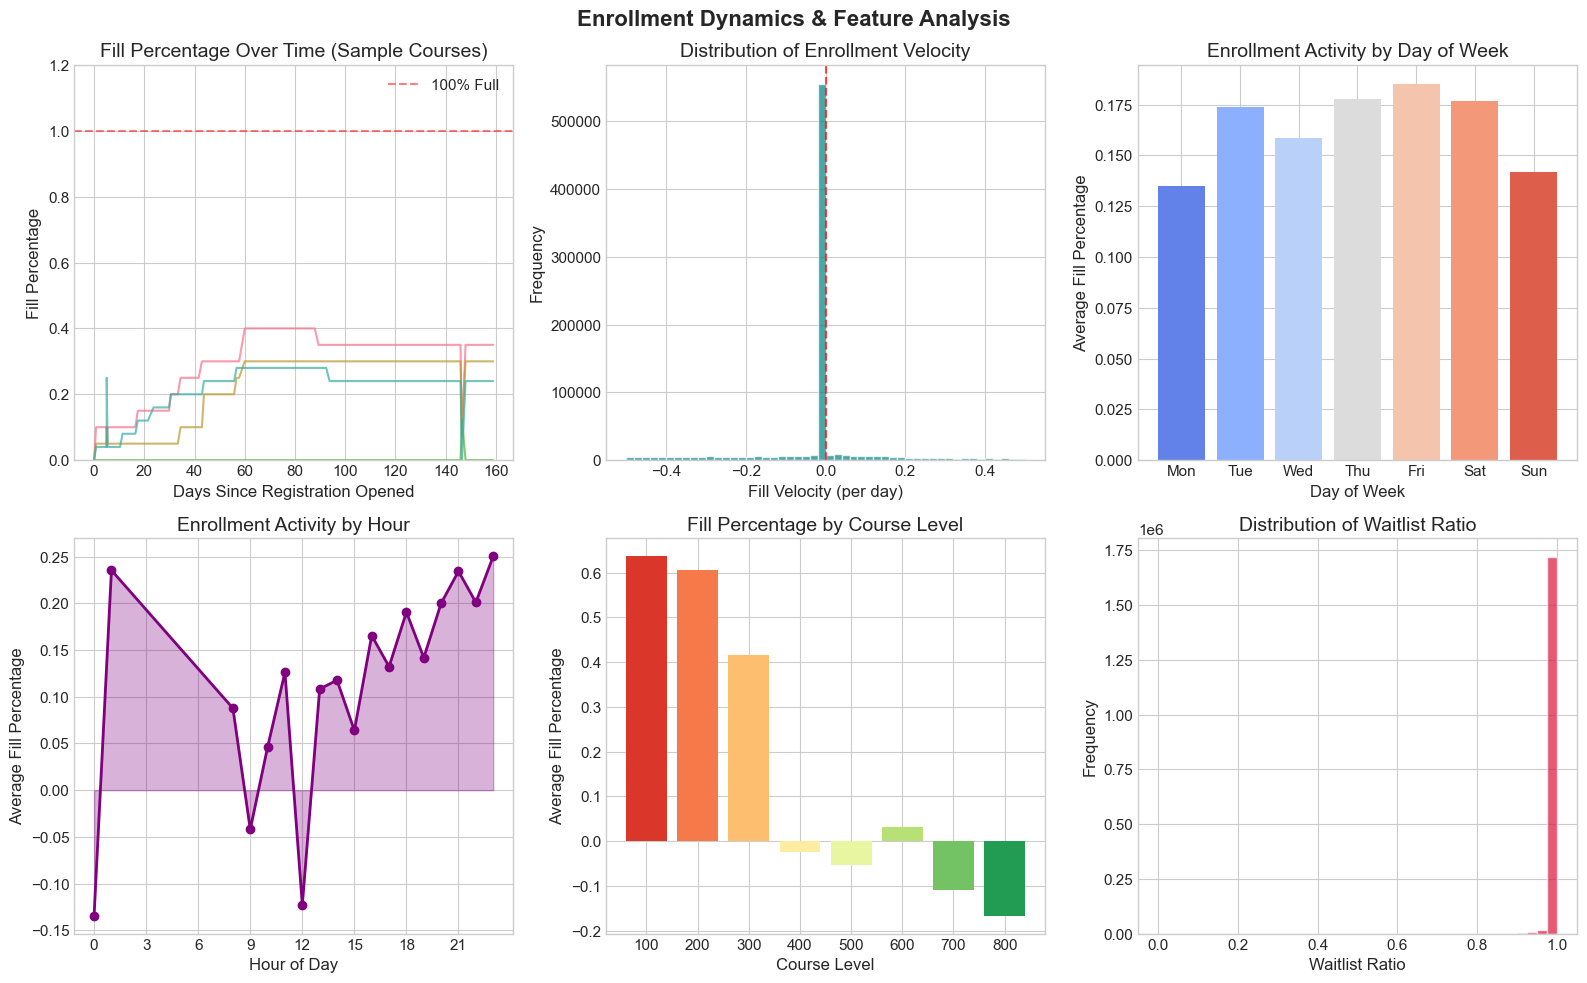


📈 Enrollment Insights:
   Average fill percentage: 16.3%
   Courses at full capacity: 1,251
   Courses with waitlists: 1,742,547


In [50]:
# ===============================================================
# VISUALIZATION 2: Enrollment Dynamics & Feature Analysis
# ===============================================================

fig, axes = plt.subplots(2, 3, figsize=(16, 10))
fig.suptitle('Enrollment Dynamics & Feature Analysis', fontsize=16, fontweight='bold')

# 1. Fill percentage over time (sampled courses)
ax1 = axes[0, 0]
sample_courses = df['classNumber'].unique()[:5]
for course in sample_courses:
    course_data = df[df['classNumber'] == course].sort_values('days_since_start')
    if len(course_data) > 5:
        ax1.plot(course_data['days_since_start'], course_data['fill_pct'], alpha=0.7, linewidth=1.5)
ax1.set_xlabel('Days Since Registration Opened')
ax1.set_ylabel('Fill Percentage')
ax1.set_title('Fill Percentage Over Time (Sample Courses)')
ax1.set_ylim(0, 1.2)
ax1.axhline(y=1.0, color='red', linestyle='--', alpha=0.5, label='100% Full')
ax1.legend()

# 2. Fill velocity distribution
ax2 = axes[0, 1]
velocity_clean = df['fill_velocity_per_day'].replace([np.inf, -np.inf], np.nan).dropna()
velocity_clean = velocity_clean[(velocity_clean > -0.5) & (velocity_clean < 0.5)]
ax2.hist(velocity_clean, bins=50, color='teal', edgecolor='white', alpha=0.7)
ax2.axvline(0, color='red', linestyle='--', alpha=0.7)
ax2.set_xlabel('Fill Velocity (per day)')
ax2.set_ylabel('Frequency')
ax2.set_title('Distribution of Enrollment Velocity')

# 3. Enrollment by day of week
ax3 = axes[0, 2]
dow_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
dow_activity = df.groupby('day_of_week')['fill_pct'].mean()
bars = ax3.bar(dow_names, dow_activity.values, color=sns.color_palette("coolwarm", 7))
ax3.set_xlabel('Day of Week')
ax3.set_ylabel('Average Fill Percentage')
ax3.set_title('Enrollment Activity by Day of Week')

# 4. Enrollment by hour of day
ax4 = axes[1, 0]
hourly_activity = df.groupby('hour')['fill_pct'].mean()
ax4.plot(hourly_activity.index, hourly_activity.values, marker='o', color='purple', linewidth=2)
ax4.fill_between(hourly_activity.index, hourly_activity.values, alpha=0.3, color='purple')
ax4.set_xlabel('Hour of Day')
ax4.set_ylabel('Average Fill Percentage')
ax4.set_title('Enrollment Activity by Hour')
ax4.set_xticks(range(0, 24, 3))

# 5. Course level vs fill percentage
ax5 = axes[1, 1]
level_fill = df.groupby('course_level')['fill_pct'].mean().dropna()
level_fill = level_fill[(level_fill.index >= 1) & (level_fill.index <= 8)]
colors = sns.color_palette("RdYlGn", len(level_fill))
bars = ax5.bar([f'{int(x)}00' for x in level_fill.index], level_fill.values, color=colors)
ax5.set_xlabel('Course Level')
ax5.set_ylabel('Average Fill Percentage')
ax5.set_title('Fill Percentage by Course Level')

# 6. Waitlist ratio distribution
ax6 = axes[1, 2]
waitlist_clean = df['waitlist_ratio'].replace([np.inf, -np.inf], np.nan).dropna()
waitlist_clean = waitlist_clean[(waitlist_clean >= 0) & (waitlist_clean <= 2)]
ax6.hist(waitlist_clean, bins=40, color='crimson', edgecolor='white', alpha=0.7)
ax6.set_xlabel('Waitlist Ratio')
ax6.set_ylabel('Frequency')
ax6.set_title('Distribution of Waitlist Ratio')

plt.tight_layout()
plt.show()

print("\n📈 Enrollment Insights:")
print(f"   Average fill percentage: {df['fill_pct'].mean():.1%}")
print(f"   Courses at full capacity: {(df.groupby('classNumber')['fill_pct'].last() >= 1.0).sum():,}")
print(f"   Courses with waitlists: {(df['waitlist_ratio'] > 0).sum():,}")


In [51]:
# ===============================================================
# 5. Time-Series Cross Validation (No Leakage)
# ===============================================================
tscv = TimeSeriesSplit(n_splits=5)

mae_scores, rmse_scores, r2_scores = [], [], []

model = XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=8,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="reg:squarederror",
    tree_method="hist"
)

for train_idx, test_idx in tscv.split(X):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    model.fit(X_train, y_train)
    preds = model.predict(X_test)

    mae_scores.append(mean_absolute_error(y_test, preds))
    rmse_scores.append(mean_squared_error(y_test, preds, squared=False))
    r2_scores.append(r2_score(y_test, preds))


print("\n========== Time-Series CV Results ==========")
print("MAE:", np.mean(mae_scores))
print("RMSE:", np.mean(rmse_scores))
print("R²:", np.mean(r2_scores))


========== Time-Series CV Results ==========
MAE: 0.06707756855273267
RMSE: 1.1354143843758162
R²: 0.7861376257075076


In [52]:
# ===============================================================
# 6. Business-Relevant Metric: ±5% Tolerance Accuracy
# ===============================================================
model.fit(X, y)
preds = model.predict(X)

tolerance = 0.05
within_tol = np.mean(np.abs(preds - y) <= tolerance)

print("\nWithin ±5% tolerance accuracy:", within_tol)


Within ±5% tolerance accuracy: 0.9814203429340088


In [53]:
# ===============================================================
# 7. Stage-Specific Performance Evaluation (per proposal requirements)
# ===============================================================
# Evaluate error separately for Early/Mid/Late stages

# Define stages based on fill percentage
df["stage"] = pd.cut(
    df["fill_pct"], 
    bins=[-np.inf, 0.25, 0.75, np.inf], 
    labels=["Early (0-25%)", "Mid (25-75%)", "Late (75-100%)"]
)

# Get predictions for the full dataset
full_preds = model.predict(X)

# Add predictions and actual values for analysis
eval_df = pd.DataFrame({
    "actual": y.values,
    "predicted": full_preds,
    "stage": df.loc[y.index, "stage"].values
})
eval_df["error"] = np.abs(eval_df["predicted"] - eval_df["actual"])

# Calculate metrics by stage
print("\n========== Stage-Specific Performance ==========")
for stage in ["Early (0-25%)", "Mid (25-75%)", "Late (75-100%)"]:
    stage_data = eval_df[eval_df["stage"] == stage]
    if len(stage_data) > 0:
        stage_mae = stage_data["error"].mean()
        stage_rmse = np.sqrt((stage_data["error"]**2).mean())
        stage_within_tol = (stage_data["error"] <= 0.05).mean()
        print(f"\n{stage}:")
        print(f"  Samples: {len(stage_data):,}")
        print(f"  MAE: {stage_mae:.4f}")
        print(f"  RMSE: {stage_rmse:.4f}")
        print(f"  Within ±5%: {stage_within_tol:.2%}")



========== Stage-Specific Performance ==========

Early (0-25%):
  Samples: 709,864
  MAE: 0.0124
  RMSE: 0.1801
  Within ±5%: 95.45%

Mid (25-75%):
  Samples: 430,786
  MAE: 0.0024
  RMSE: 0.0039
  Within ±5%: 100.00%

Late (75-100%):
  Samples: 601,901
  MAE: 0.0012
  RMSE: 0.0021
  Within ±5%: 99.99%


In [54]:
# ===============================================================
# 8. Popularity Metrics for Ranking Courses
# ===============================================================
course_groups = df.groupby("classNumber")

# Calculate Time-to-Fill Score (days to reach 90% capacity)
def calc_time_to_fill(group, threshold=0.90):
    """Calculate days to reach threshold fill percentage"""
    filled = group[group["fill_pct"] >= threshold]
    if len(filled) > 0:
        return filled["days_since_start"].min()
    return np.nan  # Never reached threshold

time_to_fill = df.groupby("classNumber").apply(calc_time_to_fill).reset_index()
time_to_fill.columns = ["classNumber", "time_to_fill_days"]

popularity = pd.DataFrame({
    "classNumber": course_groups["classNumber"].first(),
    "subjectCode": course_groups["original_subjectCode"].first(),
    "catalogNumber": course_groups["catalogNumber"].first(),
    "course_level": course_groups["course_level"].first(),
    
    # Popularity Scores (per proposal requirements):
    "final_fill_rate": course_groups["fill_pct"].last(),
    "fill_velocity_score": course_groups["fill_velocity_per_day"].mean(),
    "early_rush_score": course_groups["fill_pct"].nth(3),  # first few hours
    "waitlist_demand_score": course_groups["waitlist_ratio"].max()
})

# Merge Time-to-Fill Score
popularity = popularity.merge(time_to_fill, on="classNumber", how="left")

# Normalize time_to_fill to a score (faster fill = higher score)
# Invert so that lower time = higher score
max_days = popularity["time_to_fill_days"].max()
popularity["time_to_fill_score"] = 1 - (popularity["time_to_fill_days"] / max_days)
popularity["time_to_fill_score"] = popularity["time_to_fill_score"].fillna(0)

# Replace inf/-inf with NaN, then fill with 0 for composite calculation
popularity = popularity.replace([np.inf, -np.inf], np.nan)
popularity = popularity.fillna(0)

# Composite Score (updated weights to include time_to_fill)
popularity["popularity_score"] = (
    0.30 * popularity["final_fill_rate"] +
    0.25 * popularity["fill_velocity_score"] +
    0.20 * popularity["time_to_fill_score"] +  # Added per proposal
    0.15 * popularity["waitlist_demand_score"] +
    0.10 * popularity["early_rush_score"]
)

print(f"Popularity metrics calculated for {len(popularity)} courses")
print(f"\nPopularity metrics include:")
print("  - Final Fill Rate")
print("  - Fill Velocity Score") 
print("  - Time-to-Fill Score (days to 90% capacity)")
print("  - Waitlist Demand Score")
print("  - Early Rush Score")
print("  - Composite Popularity Score")

Popularity metrics calculated for 19890 courses

Popularity metrics include:
  - Final Fill Rate
  - Fill Velocity Score
  - Time-to-Fill Score (days to 90% capacity)
  - Waitlist Demand Score
  - Early Rush Score
  - Composite Popularity Score


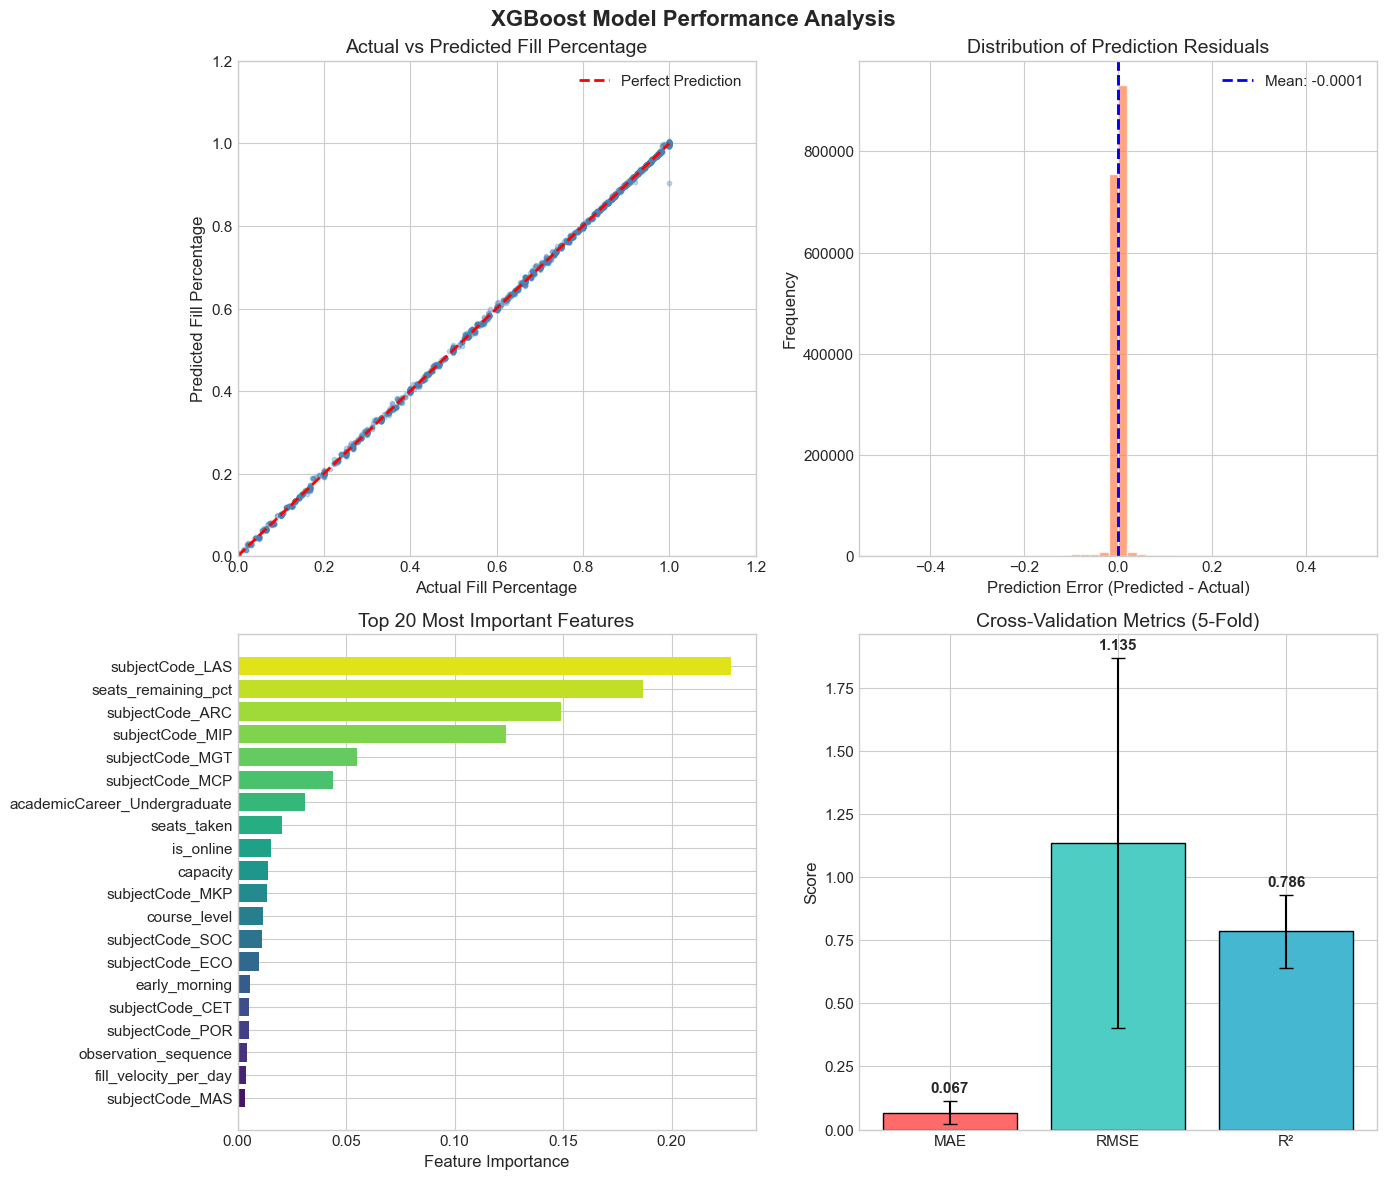


🎯 Model Performance Summary:
   Mean Absolute Error: 0.0671
   Root Mean Squared Error: 1.1354
   R² Score: 0.7861
   Within ±5% Tolerance: 98.14%


In [55]:
# ===============================================================
# VISUALIZATION 3: Model Performance & Feature Importance
# ===============================================================

fig, axes = plt.subplots(2, 2, figsize=(14, 12))
fig.suptitle('XGBoost Model Performance Analysis', fontsize=16, fontweight='bold')

# 1. Actual vs Predicted scatter plot
ax1 = axes[0, 0]
sample_idx = np.random.choice(len(y), min(5000, len(y)), replace=False)
ax1.scatter(y.iloc[sample_idx], preds[sample_idx], alpha=0.3, s=10, c='steelblue')
ax1.plot([0, 1], [0, 1], 'r--', linewidth=2, label='Perfect Prediction')
ax1.set_xlabel('Actual Fill Percentage')
ax1.set_ylabel('Predicted Fill Percentage')
ax1.set_title('Actual vs Predicted Fill Percentage')
ax1.legend()
ax1.set_xlim(0, 1.2)
ax1.set_ylim(0, 1.2)

# 2. Residual distribution
ax2 = axes[0, 1]
residuals = preds - y.values
residuals_clean = residuals[(residuals > -0.5) & (residuals < 0.5)]
ax2.hist(residuals_clean, bins=50, color='coral', edgecolor='white', alpha=0.7)
ax2.axvline(0, color='red', linestyle='--', linewidth=2)
ax2.axvline(np.mean(residuals_clean), color='blue', linestyle='--', linewidth=2, label=f'Mean: {np.mean(residuals_clean):.4f}')
ax2.set_xlabel('Prediction Error (Predicted - Actual)')
ax2.set_ylabel('Frequency')
ax2.set_title('Distribution of Prediction Residuals')
ax2.legend()

# 3. Feature Importance (Top 20)
ax3 = axes[1, 0]
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=True).tail(20)

colors = sns.color_palette("viridis", len(feature_importance))
ax3.barh(feature_importance['feature'], feature_importance['importance'], color=colors)
ax3.set_xlabel('Feature Importance')
ax3.set_title('Top 20 Most Important Features')

# 4. Cross-Validation Scores
ax4 = axes[1, 1]
metrics = ['MAE', 'RMSE', 'R²']
cv_means = [np.mean(mae_scores), np.mean(rmse_scores), np.mean(r2_scores)]
cv_stds = [np.std(mae_scores), np.std(rmse_scores), np.std(r2_scores)]

x_pos = np.arange(len(metrics))
bars = ax4.bar(x_pos, cv_means, yerr=cv_stds, capsize=5, color=['#FF6B6B', '#4ECDC4', '#45B7D1'], edgecolor='black')
ax4.set_xticks(x_pos)
ax4.set_xticklabels(metrics)
ax4.set_ylabel('Score')
ax4.set_title('Cross-Validation Metrics (5-Fold)')

# Add value labels on bars
for bar, mean, std in zip(bars, cv_means, cv_stds):
    ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + std + 0.02, 
             f'{mean:.3f}', ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n🎯 Model Performance Summary:")
print(f"   Mean Absolute Error: {np.mean(mae_scores):.4f}")
print(f"   Root Mean Squared Error: {np.mean(rmse_scores):.4f}")
print(f"   R² Score: {np.mean(r2_scores):.4f}")
print(f"   Within ±5% Tolerance: {within_tol:.2%}")


In [56]:
# ===============================================================
# 9. Ranking Courses (CSC, ECE by 200/300/400 level)
# ===============================================================

# Get unique subject codes to see what's available
print("Available subject codes (sample):", list(popularity["subjectCode"].unique()[:20]))

target_subjects = ["CSC", "ECE"]
filtered = popularity[popularity["subjectCode"].isin(target_subjects)]
print(f"\nFiltered courses: CSC={len(filtered[filtered['subjectCode']=='CSC'])}, ECE={len(filtered[filtered['subjectCode']=='ECE'])}")

ranked_output = {}

# Note: course_level = catalogNumber // 100, so:
# - 200-level courses have course_level = 2
# - 300-level courses have course_level = 3
# - 400-level courses have course_level = 4
level_mapping = {200: 2, 300: 3, 400: 4}

for subj in target_subjects:
    subj_df = filtered[filtered["subjectCode"] == subj]
    ranked_output[subj] = {}

    for display_level, actual_level in level_mapping.items():
        lvl = subj_df[subj_df["course_level"] == actual_level]
        ranked_output[subj][display_level] = lvl.sort_values(
            "popularity_score", ascending=False
        ).head(10)  # top 10

# Print Rankings
print("\n=========== Top CSC 200-Level Courses ===========")
if len(ranked_output["CSC"][200]) > 0:
    print(ranked_output["CSC"][200][["classNumber", "catalogNumber", "popularity_score", "final_fill_rate"]].head())
else:
    print("No CSC 200-level courses found")

print("\n=========== Top CSC 300-Level Courses ===========")
if len(ranked_output["CSC"][300]) > 0:
    print(ranked_output["CSC"][300][["classNumber", "catalogNumber", "popularity_score", "final_fill_rate"]].head())
else:
    print("No CSC 300-level courses found")

print("\n=========== Top ECE 300-Level Courses ===========")
if len(ranked_output["ECE"][300]) > 0:
    print(ranked_output["ECE"][300][["classNumber", "catalogNumber", "popularity_score", "final_fill_rate"]].head())
else:
    print("No ECE 300-level courses found")

print("\n=========== Top ECE 400-Level Courses ===========")
if len(ranked_output["ECE"][400]) > 0:
    print(ranked_output["ECE"][400][["classNumber", "catalogNumber", "popularity_score", "final_fill_rate"]].head())
else:
    print("No ECE 400-level courses found")

# Export results
popularity.to_csv("course_popularity_scores.csv", index=False)
print(f"\n✓ Popularity scores saved to course_popularity_scores.csv")

Available subject codes (sample): [0, 'CTI', 'MIC', 'GNM', 'SAP', 'KIN', 'DER', 'MGT', 'MDB', 'EPS', 'MCP', 'UMX', 'GSC', 'MGS', 'JMM', 'ATM', 'MSC', 'TAL', 'COM', 'COS']

Filtered courses: CSC=128, ECE=151

=========== Top CSC 200-Level Courses ===========
      classNumber  catalogNumber  popularity_score  final_fill_rate
2720         3735          298.0         18.714496         0.800000
8082         9099          298.0          0.560611         0.725000
8058         9075          210.0          0.482136         0.463415
8044         9061          220.0          0.382500         0.775000
2686         3701          220.0          0.350000         0.000000

=========== Top CSC 300-Level Courses ===========
      classNumber  catalogNumber  popularity_score  final_fill_rate
8056         9073          329.0          0.639070         0.980000
8036         9053          322.0          0.485138         0.700000
2728         3743          315.0          0.358571         0.028571
2677       

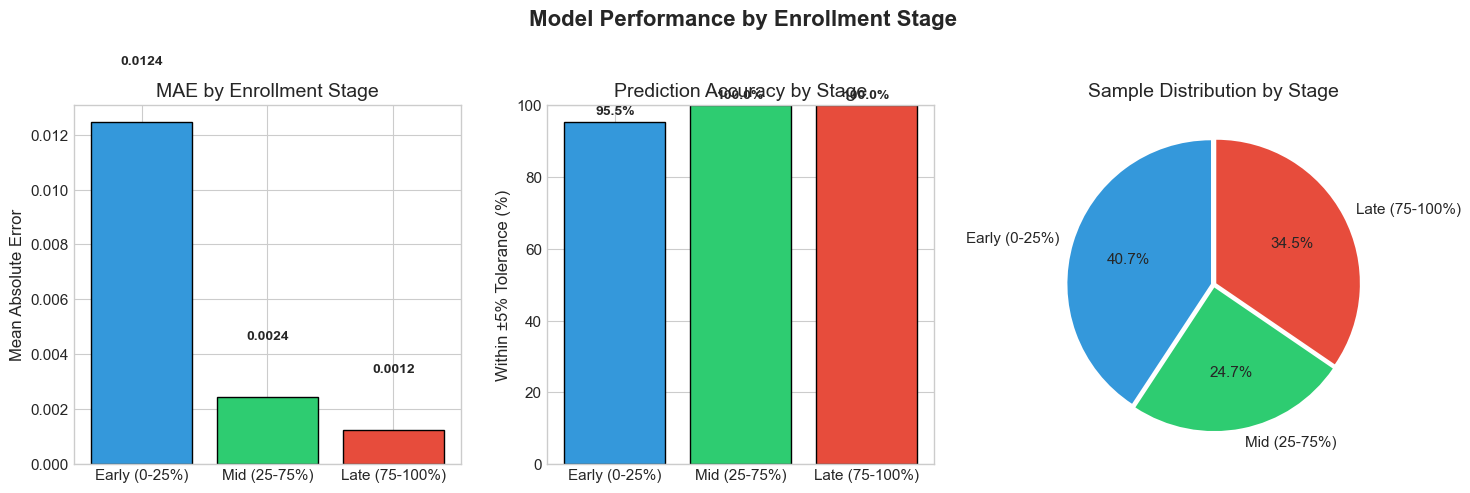


📊 Stage-Specific Insights:
   Early (0-25%): MAE=0.0124, Accuracy=95.5%, Samples=709,864
   Mid (25-75%): MAE=0.0024, Accuracy=100.0%, Samples=430,786
   Late (75-100%): MAE=0.0012, Accuracy=100.0%, Samples=601,901


In [57]:
# ===============================================================
# VISUALIZATION 4: Stage-Specific Performance Analysis
# ===============================================================

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('Model Performance by Enrollment Stage', fontsize=16, fontweight='bold')

stage_metrics = {}
stages = ["Early (0-25%)", "Mid (25-75%)", "Late (75-100%)"]
stage_colors = ['#3498db', '#2ecc71', '#e74c3c']

for stage in stages:
    stage_data = eval_df[eval_df["stage"] == stage]
    if len(stage_data) > 0:
        stage_metrics[stage] = {
            'mae': stage_data["error"].mean(),
            'rmse': np.sqrt((stage_data["error"]**2).mean()),
            'within_tol': (stage_data["error"] <= 0.05).mean(),
            'count': len(stage_data)
        }

# 1. MAE by stage
ax1 = axes[0]
mae_values = [stage_metrics.get(s, {}).get('mae', 0) for s in stages]
bars1 = ax1.bar(stages, mae_values, color=stage_colors, edgecolor='black')
ax1.set_ylabel('Mean Absolute Error')
ax1.set_title('MAE by Enrollment Stage')
for bar, val in zip(bars1, mae_values):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.002, 
             f'{val:.4f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

# 2. Within Tolerance by stage
ax2 = axes[1]
tol_values = [stage_metrics.get(s, {}).get('within_tol', 0) * 100 for s in stages]
bars2 = ax2.bar(stages, tol_values, color=stage_colors, edgecolor='black')
ax2.set_ylabel('Within ±5% Tolerance (%)')
ax2.set_title('Prediction Accuracy by Stage')
ax2.set_ylim(0, 100)
for bar, val in zip(bars2, tol_values):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
             f'{val:.1f}%', ha='center', va='bottom', fontsize=10, fontweight='bold')

# 3. Sample distribution by stage
ax3 = axes[2]
counts = [stage_metrics.get(s, {}).get('count', 0) for s in stages]
wedges, texts, autotexts = ax3.pie(counts, labels=stages, autopct='%1.1f%%', 
                                    colors=stage_colors, startangle=90, explode=[0.02, 0.02, 0.02])
ax3.set_title('Sample Distribution by Stage')

plt.tight_layout()
plt.show()

print("\n📊 Stage-Specific Insights:")
for stage in stages:
    if stage in stage_metrics:
        m = stage_metrics[stage]
        print(f"   {stage}: MAE={m['mae']:.4f}, Accuracy={m['within_tol']:.1%}, Samples={m['count']:,}")


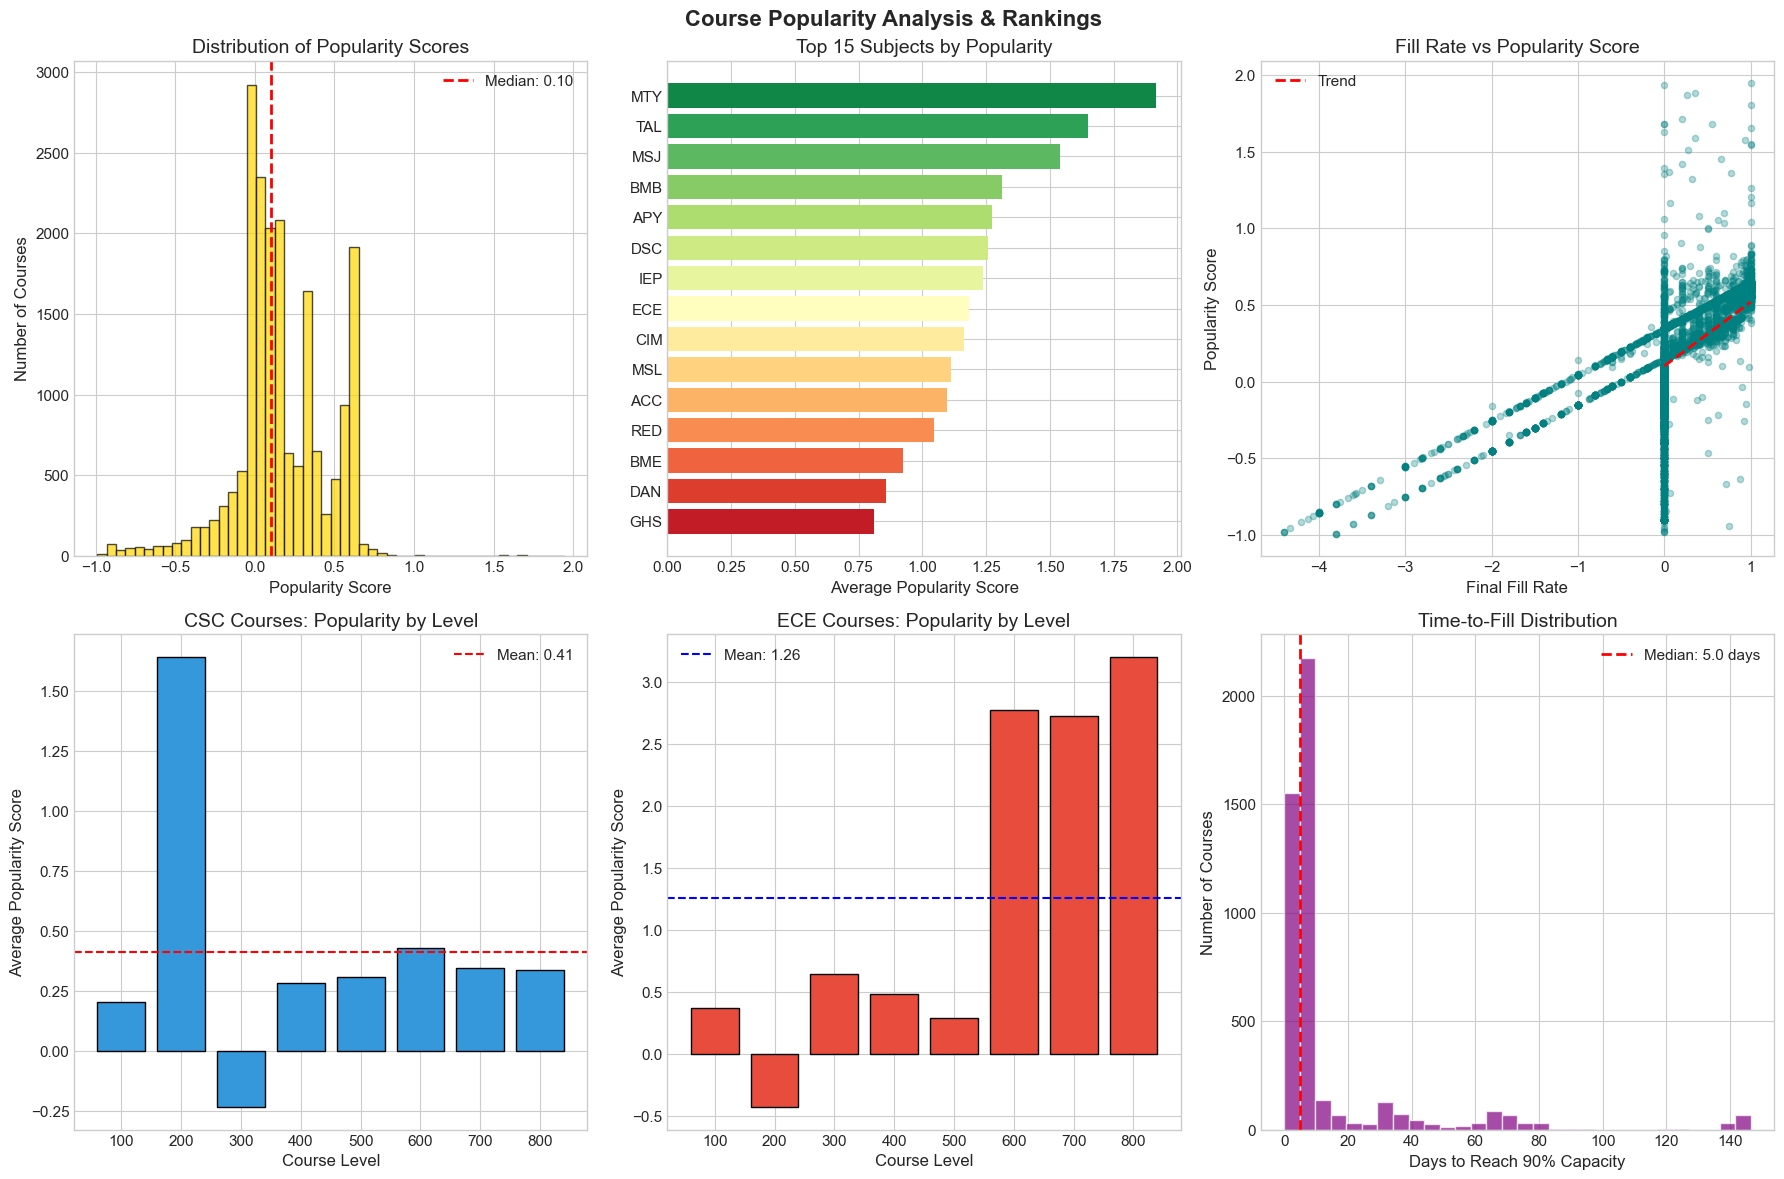


🏆 Popularity Summary:
   Total courses analyzed: 19,890
   CSC courses: 128
   ECE courses: 151
   Median popularity score: 0.100


In [58]:
# ===============================================================
# VISUALIZATION 5: Course Popularity & Rankings Analysis
# ===============================================================

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Course Popularity Analysis & Rankings', fontsize=16, fontweight='bold')

# 1. Distribution of popularity scores
ax1 = axes[0, 0]
pop_scores = popularity['popularity_score'].replace([np.inf, -np.inf], np.nan).dropna()
pop_scores = pop_scores[(pop_scores > -1) & (pop_scores < 2)]
ax1.hist(pop_scores, bins=50, color='gold', edgecolor='black', alpha=0.7)
ax1.axvline(pop_scores.median(), color='red', linestyle='--', linewidth=2, label=f'Median: {pop_scores.median():.2f}')
ax1.set_xlabel('Popularity Score')
ax1.set_ylabel('Number of Courses')
ax1.set_title('Distribution of Popularity Scores')
ax1.legend()

# 2. Top 15 subjects by average popularity
ax2 = axes[0, 1]
subject_pop = popularity.groupby('subjectCode')['popularity_score'].mean()
subject_pop = subject_pop.replace([np.inf, -np.inf], np.nan).dropna()
subject_pop = subject_pop[(subject_pop > -1) & (subject_pop < 2)].sort_values(ascending=False).head(15)
colors = sns.color_palette("RdYlGn_r", len(subject_pop))
bars = ax2.barh(subject_pop.index, subject_pop.values, color=colors)
ax2.set_xlabel('Average Popularity Score')
ax2.set_title('Top 15 Subjects by Popularity')
ax2.invert_yaxis()

# 3. Fill rate vs Popularity correlation
ax3 = axes[0, 2]
pop_clean = popularity[['final_fill_rate', 'popularity_score']].replace([np.inf, -np.inf], np.nan).dropna()
pop_clean = pop_clean[(pop_clean['popularity_score'] > -1) & (pop_clean['popularity_score'] < 2)]
ax3.scatter(pop_clean['final_fill_rate'], pop_clean['popularity_score'], alpha=0.3, s=20, c='teal')
ax3.set_xlabel('Final Fill Rate')
ax3.set_ylabel('Popularity Score')
ax3.set_title('Fill Rate vs Popularity Score')
# Add trend line
z = np.polyfit(pop_clean['final_fill_rate'], pop_clean['popularity_score'], 1)
p = np.poly1d(z)
ax3.plot([0, 1], [p(0), p(1)], "r--", linewidth=2, label='Trend')
ax3.legend()

# 4. CSC Courses by Level
ax4 = axes[1, 0]
csc_pop = popularity[popularity['subjectCode'] == 'CSC']
csc_by_level = csc_pop.groupby('course_level')['popularity_score'].mean()
csc_by_level = csc_by_level.replace([np.inf, -np.inf], np.nan).dropna()
csc_by_level = csc_by_level[(csc_by_level.index >= 1) & (csc_by_level.index <= 8)]
ax4.bar([f'{int(x)}00' for x in csc_by_level.index], csc_by_level.values, color='#3498db', edgecolor='black')
ax4.set_xlabel('Course Level')
ax4.set_ylabel('Average Popularity Score')
ax4.set_title('CSC Courses: Popularity by Level')
ax4.axhline(csc_by_level.mean(), color='red', linestyle='--', label=f'Mean: {csc_by_level.mean():.2f}')
ax4.legend()

# 5. ECE Courses by Level
ax5 = axes[1, 1]
ece_pop = popularity[popularity['subjectCode'] == 'ECE']
ece_by_level = ece_pop.groupby('course_level')['popularity_score'].mean()
ece_by_level = ece_by_level.replace([np.inf, -np.inf], np.nan).dropna()
ece_by_level = ece_by_level[(ece_by_level.index >= 1) & (ece_by_level.index <= 8)]
ax5.bar([f'{int(x)}00' for x in ece_by_level.index], ece_by_level.values, color='#e74c3c', edgecolor='black')
ax5.set_xlabel('Course Level')
ax5.set_ylabel('Average Popularity Score')
ax5.set_title('ECE Courses: Popularity by Level')
ax5.axhline(ece_by_level.mean(), color='blue', linestyle='--', label=f'Mean: {ece_by_level.mean():.2f}')
ax5.legend()

# 6. Time to Fill Distribution
ax6 = axes[1, 2]
ttf = popularity['time_to_fill_days'].replace([np.inf, -np.inf], np.nan).dropna()
ttf = ttf[ttf > 0]
if len(ttf) > 0:
    ax6.hist(ttf, bins=30, color='purple', edgecolor='white', alpha=0.7)
    ax6.axvline(ttf.median(), color='red', linestyle='--', linewidth=2, label=f'Median: {ttf.median():.1f} days')
    ax6.set_xlabel('Days to Reach 90% Capacity')
    ax6.set_ylabel('Number of Courses')
    ax6.set_title('Time-to-Fill Distribution')
    ax6.legend()
else:
    ax6.text(0.5, 0.5, 'No courses reached 90%', ha='center', va='center', transform=ax6.transAxes)
    ax6.set_title('Time-to-Fill Distribution')

plt.tight_layout()
plt.show()

# Print summary statistics
print("\n🏆 Popularity Summary:")
print(f"   Total courses analyzed: {len(popularity):,}")
print(f"   CSC courses: {len(csc_pop)}")
print(f"   ECE courses: {len(ece_pop)}")
print(f"   Median popularity score: {pop_scores.median():.3f}")


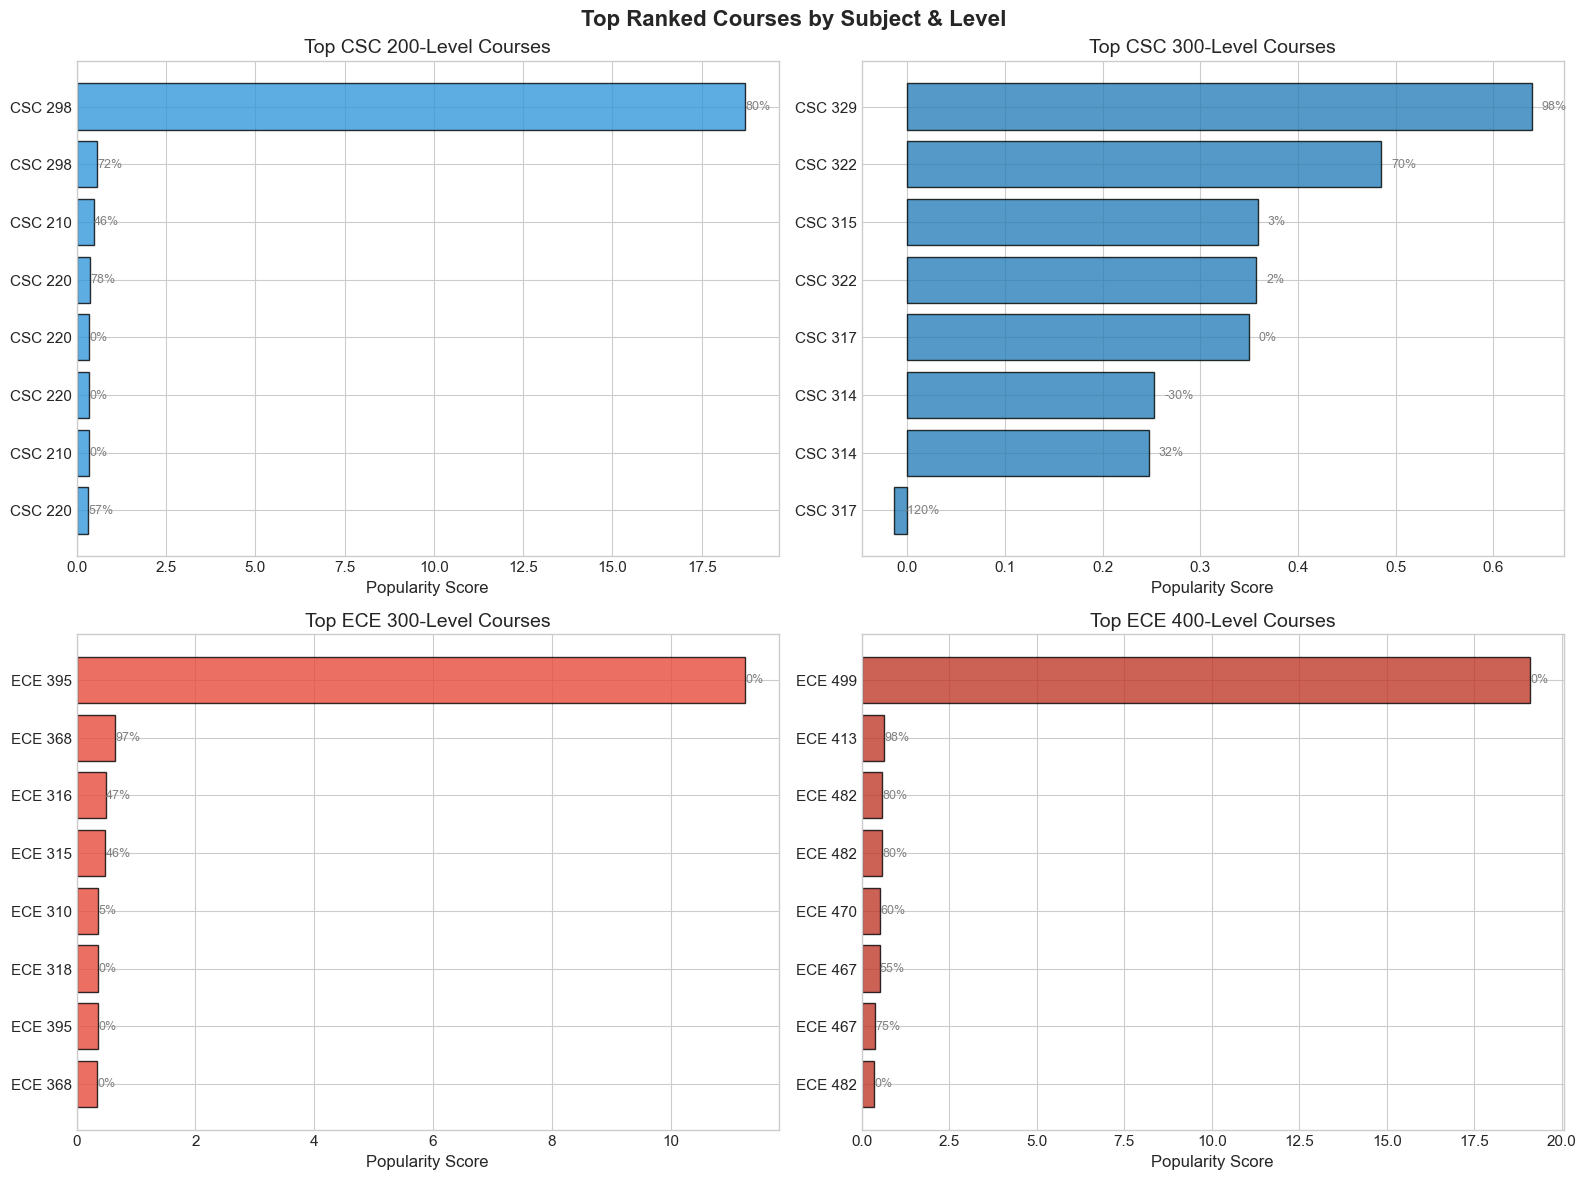


📋 TOP COURSE RANKINGS SUMMARY

CSC Department:
----------------------------------------

  200-Level Top 3:
    • CSC 298: Score=18.714, Fill=80%
    • CSC 298: Score=0.561, Fill=72%
    • CSC 210: Score=0.482, Fill=46%

  300-Level Top 3:
    • CSC 329: Score=0.639, Fill=98%
    • CSC 322: Score=0.485, Fill=70%
    • CSC 315: Score=0.359, Fill=3%

  400-Level Top 3:
    • CSC 410: Score=0.643, Fill=100%
    • CSC 421: Score=0.568, Fill=75%
    • CSC 423: Score=0.566, Fill=80%

ECE Department:
----------------------------------------

  200-Level Top 3:
    • ECE 212: Score=1.714, Fill=20%
    • ECE 212: Score=0.631, Fill=96%
    • ECE 212: Score=0.603, Fill=87%

  300-Level Top 3:
    • ECE 395: Score=11.256, Fill=0%
    • ECE 368: Score=0.638, Fill=97%
    • ECE 316: Score=0.485, Fill=47%

  400-Level Top 3:
    • ECE 499: Score=19.097, Fill=0%
    • ECE 413: Score=0.643, Fill=98%
    • ECE 482: Score=0.583, Fill=80%


In [59]:
# ===============================================================
# VISUALIZATION 6: Top Course Rankings Visualization
# ===============================================================

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Top Ranked Courses by Subject & Level', fontsize=16, fontweight='bold')

level_mapping = {200: 2, 300: 3, 400: 4}

# Function to create ranking bar chart
def plot_top_courses(ax, subject, level, color):
    actual_level = level_mapping[level]
    subj_df = popularity[(popularity['subjectCode'] == subject) & (popularity['course_level'] == actual_level)]
    subj_df = subj_df.replace([np.inf, -np.inf], np.nan)
    subj_df = subj_df.dropna(subset=['popularity_score'])
    top_courses = subj_df.sort_values('popularity_score', ascending=False).head(8)
    
    if len(top_courses) > 0:
        y_pos = np.arange(len(top_courses))
        bars = ax.barh(y_pos, top_courses['popularity_score'].values, color=color, edgecolor='black', alpha=0.8)
        ax.set_yticks(y_pos)
        ax.set_yticklabels([f"{subject} {int(c)}" for c in top_courses['catalogNumber']])
        ax.set_xlabel('Popularity Score')
        ax.set_title(f'Top {subject} {level}-Level Courses')
        ax.invert_yaxis()
        
        # Add fill rate as text
        for i, (bar, fr) in enumerate(zip(bars, top_courses['final_fill_rate'])):
            ax.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2, 
                   f'{fr:.0%}', va='center', fontsize=9, color='gray')
    else:
        ax.text(0.5, 0.5, f'No {subject} {level}-level courses', ha='center', va='center', transform=ax.transAxes)
        ax.set_title(f'Top {subject} {level}-Level Courses')

# Plot top courses for each subject/level combination
plot_top_courses(axes[0, 0], 'CSC', 200, '#3498db')
plot_top_courses(axes[0, 1], 'CSC', 300, '#2980b9')
plot_top_courses(axes[1, 0], 'ECE', 300, '#e74c3c')
plot_top_courses(axes[1, 1], 'ECE', 400, '#c0392b')

plt.tight_layout()
plt.show()

# Summary table
print("\n" + "="*70)
print("📋 TOP COURSE RANKINGS SUMMARY")
print("="*70)

for subject in ['CSC', 'ECE']:
    print(f"\n{subject} Department:")
    print("-" * 40)
    for display_level, actual_level in level_mapping.items():
        subj_df = popularity[(popularity['subjectCode'] == subject) & (popularity['course_level'] == actual_level)]
        subj_df = subj_df.replace([np.inf, -np.inf], np.nan).dropna(subset=['popularity_score'])
        if len(subj_df) > 0:
            top = subj_df.sort_values('popularity_score', ascending=False).head(3)
            print(f"\n  {display_level}-Level Top 3:")
            for _, row in top.iterrows():
                print(f"    • {subject} {int(row['catalogNumber'])}: Score={row['popularity_score']:.3f}, Fill={row['final_fill_rate']:.0%}")
